In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 13.3: The Generalized Linear Model

## Objectives

+ To regression using a generalized linear model

## The generalized linear model

The form of the generalized linear model is:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}
$$
where $\mathbf{w} = (w_{1}, ... , w_{m})^{T}$ and $\boldsymbol{\phi} = (\phi_{1}, ..., \phi_{m})^{T}$ are arbitrary basis functions.
Note that the model is linear in $\mathbf{w}$ not $\mathbf{x}$, but the basis functions $\boldsymbol{\phi}(\mathbf{x})$ can be non-linear.

## The polynomial model as a generalized linear model
We have already seen an example of a generalized linear model when $\mathbf{x}$ has only one dimension: the polynomial model.
In the polynomial model, the basis functions are:
$$
\phi_1(x) = 1,
$$
$$
\phi_2(x) = x,
$$
$$
\phi_3(x) = x^2,
$$
and so on.
This is just one of the possible choices.

## Multivariate linear regression as a generalized linear model
In multivariate linear regression the inputs $\mathbf{x}$ have $d$ dimensions, say $\mathbf{x}=(x_1,\dots,x_d)$.
The linear model is:
$$
y = w_0 + w_1x_1 + w_2x_2 + \dots w_dx_d.
$$
This is also a generalized linear model with $m=d+1$ basis functions:
$$
\phi_1(\mathbf{x}) = 1,
$$
$$
\phi_2(\mathbf{x}) = x_1,
$$
$$
\phi_3(\mathbf{x}) = x_2,
$$
and so on.

## Other generalized linear models
Some common examples of generalized linear moedls include:
+ Multi-dimensional polynomials, $\phi_j(\mathbf{x}) = \sum_{\alpha\in\mathcal{A}_j}\beta_{\alpha}\mathbf{x}^{\alpha}$,
where we are using the [multi-index notation](https://en.wikipedia.org/wiki/Multi-index_notation) to save some space.
+ Radial basis functions, $\phi_j(\mathbf{x}) = \exp\left\{-\frac{\parallel \mathbf{x} - \mathbf{x}_j\parallel^2}{2\ell^2}\right\}$.
+ Fourier series, $\phi_{2j}(x) = \cos\left(\frac{2j\pi}{L}x\right)$ and $\phi_{2j+1}(x)=\sin\left(\frac{2j\pi}{L}x\right)$.
+ $\dots$
We will play with that last two in this hands-on activity.

## Fitting the generalized linear model using least squares

The idea is to find the best $\mathbf{w}$ by minimizing a quadratic loss function:
$$
\mathcal{L}(\mathbf{w})\equiv\mathcal{L}(\mathbf{w};\mathbf{x}_{1:n},\mathbf{y}_{1:n}) = \sum_{i=1}^n\left[y(\mathbf{x}_i;\mathbf{w}) - y_i\right]^2.
$$
As we discussed in the lecture, the loss function can be re-expressed as:
$$
\begin{array}{ccc}
\mathcal{L}(\mathbf{w}) &=& \lVert\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\rVert^2\\
&=& \left(\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\right)^T\left(\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}_{1:n}\right).
\end{array}
$$
Here $\boldsymbol{\Phi}\in\mathbb{R}^{n\times m}$ is the **design matrix**:
$$
\Phi_{ij} = \phi_j(\mathbf{x}_j).
$$

To minimize the loss function, we follow these steps:
+ Take the derivative of $\mathcal{L}(\mathbf{w})$ with respect to $\mathbf{w}$.
+ Set it equal to zero and solve for $\mathbf{w}$.
+ You will get [(Bishop, 2006)](http://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738):
$$
\mathbf{w}_{\mbox{LS}} = \left(\mathbf{\Phi}^{T}\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^{T}\mathbf{y}_{1:n}.
$$

To solve this problem, just use:

> [numpy.linalg.lstsq](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.lstsq.html)

You give it $\mathbf{\Phi}$ and $\mathbf{y}_{1:n}$ and it returns $\mathbf{w}_{\mbox{LS}}$.

## Example - Motorcycle data with polynomials

Let's load the the motorcycle data to demonstrate generalized linear models.
Just like before, you need to make sure that the data file is in the current working directory of this Jupyter notebook.
The data file is [here](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/motor.dat).
You can follow the instructions of [Problem 0 of Homework 3](https://colab.research.google.com/github/PredictiveScienceLab/data-analytics-se/blob/master/homework/homework_03.ipynb) to put it in your Google Drive, mount the Google Drive, and then change into that directory.
In this handout, we will do something faster: we will just download the data file to the current working directory.
This is not a good choice for big files, but it will work just fine for this one.
Here we go:

In [2]:
# The url of the file we want to download
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/motor.dat'
# If you are interested in understanding what the function download does, see the header
# of this Jupyter notebook
download(url)

We should now have the file. Let's load it and visualize the data:

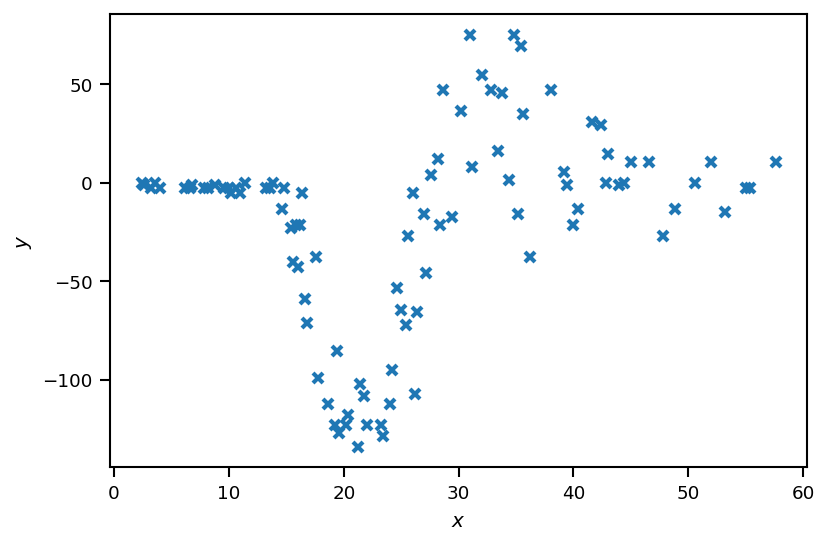

In [3]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]
fig, ax = plt.subplots(dpi=150)
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's start with polynomial regression.
We just need to write code that calculates the design matrix.
Here is tghe code:

In [4]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

Here is how the design matrix for degree 3 polynomial looks like:

In [5]:
Phi = get_polynomial_design_matrix(X, 3)
print(Phi[:5, :])

[[ 1.     2.4    5.76  13.824]
 [ 1.     2.6    6.76  17.576]
 [ 1.     3.2   10.24  32.768]
 [ 1.     3.6   12.96  46.656]
 [ 1.     4.    16.    64.   ]]


Let's now visualize the polynomials as a function of $x$ so that you get some intuition about how $y$ is expanded:

Text(0.5, 0, '$x$')

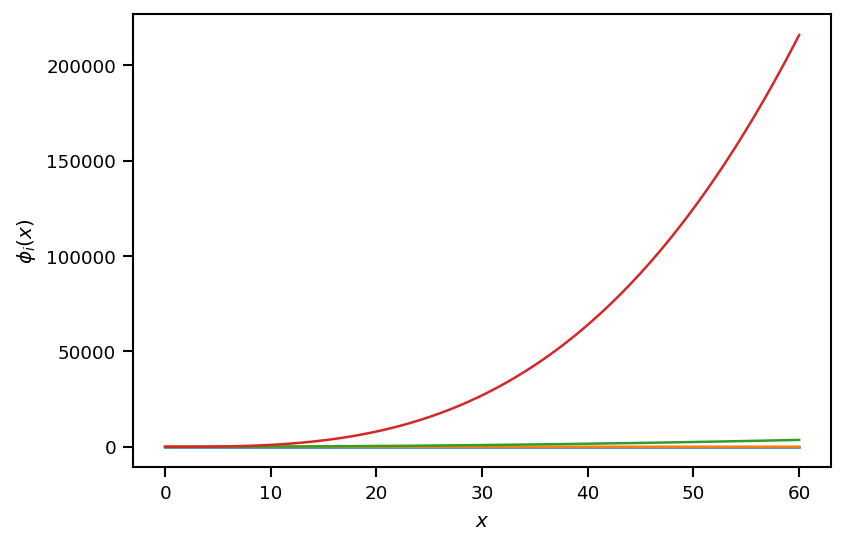

In [6]:
fig, ax = plt.subplots(dpi=150)
xx = np.linspace(0, 60, 200)
Phi_xx = get_polynomial_design_matrix(xx[:, None], 3)
plt.plot(xx, Phi_xx)
plt.ylabel(r'$\phi_i(x)$')
plt.xlabel('$x$')

Let's now solve the least squares problem:

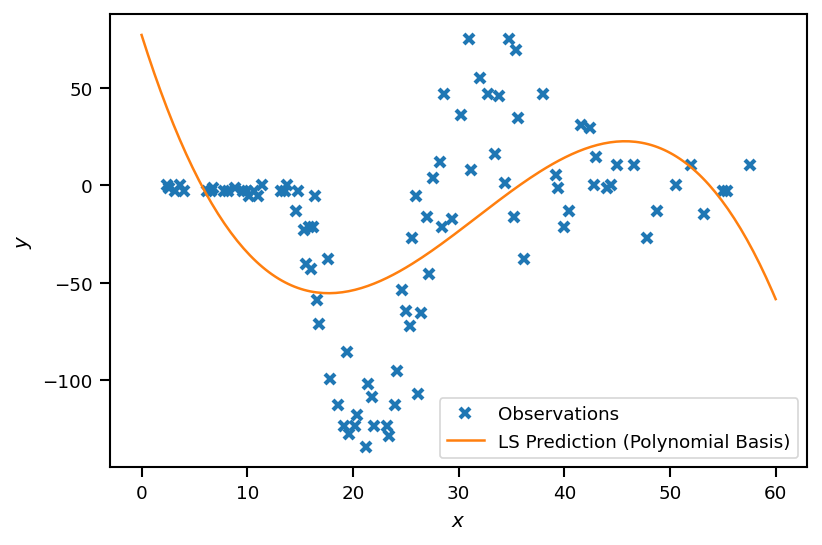

In [7]:
# Pick the polynomial degree
degree = 3
# Make the design matrix
Phi = get_polynomial_design_matrix(X, degree)
# Solve least squares problem
w_LS = np.linalg.lstsq(Phi, Y, rcond=None)[0]
# Make prediction at a dense set of points
xx = np.linspace(0, 60, 200)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
Y_p = np.dot(Phi_xx, w_LS)
# Plot the predictions
fig, ax = plt.subplots(dpi=150)
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(xx, Y_p, label='LS Prediction (Polynomial Basis)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Questions

+ Experiment with polynomials of degree 4, 5, 10, 20
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?

## Example - Motorcycle data with Fourier basis

Let's now repeat what we did with polynomial regression with a Fourier basis.
The mathematical form of the basis is:
$$
\phi_{2j}(x) = \cos\left(\frac{2j\pi}{L}x)\right),
$$
and
$$
\phi_{2j+1}(x) = \sin\left(\frac{2j\pi}{L}x)\right),
$$
for $j=1,\dots,m/2$.
First, we write code that computes the design matrix for the new basis:

In [8]:
def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    
        L           -       The "length" of the domain.
        num_terms   -       How many Fourier terms do you want. This is not the number
                            of basis functions you get. The number of basis functions
                            is 1 + num_terms / 2. The first one is a constant.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)

Let's start by visualizing the Fourier basis:

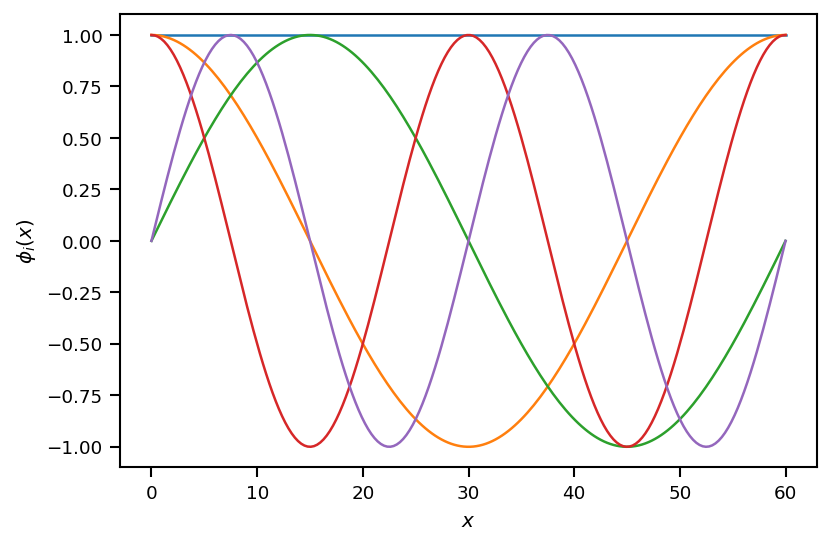

In [9]:
fig, ax = plt.subplots(dpi=150)
xx = np.linspace(0, 60, 200)
Phi_xx = get_fourier_design_matrix(xx[:, None], 60.0, 4)
plt.plot(xx, Phi_xx)
plt.ylabel(r'$\phi_i(x)$')
plt.xlabel('$x$');

Let's now solve the least squares problem:

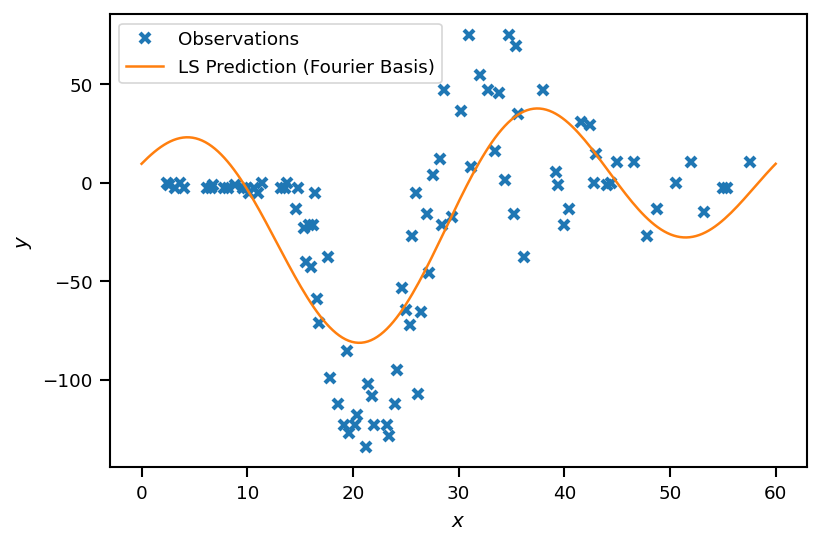

In [10]:
# Pick the parameters of the Fourier basis
L = 60.0
num_terms = 4
# Make the design matrix
Phi = get_fourier_design_matrix(X, L, num_terms)
# Solve least squares problem
w_LS = np.linalg.lstsq(Phi, Y, rcond=None)[0]
# Make prediction at a dense set of points
xx = np.linspace(0, 60, 200)
Phi_xx = get_fourier_design_matrix(xx[:, None], L, num_terms)
Y_p = np.dot(Phi_xx, w_LS)
# Plot the predictions
fig, ax = plt.subplots(dpi=150)
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(xx, Y_p, label='LS Prediction (Fourier Basis)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Questions

+ Experiment with 4, 10, 20, 40, terms.
+ When are we underfitting?
+ When are we overfitting?
+ Which one (if any) gives you the best fit?

## Example - Motorcycle data with Fourier basis

Let's now try out the radial basis functions.
The mathematical form is:
$$
\phi_i(x) = \exp\left\{-\frac{(x-x_i^c)^2}{2\ell^2}\right\},
$$
where $x_i^c$ are points about each the basis functions are centered.
We start with the code that evaluates the design matrix:

In [ ]:
def get_rbf_design_matrix(x, x_centers, ell):
    """
    Radial basis functions design matrix.
    
    Arguments:
        x          -     the input points on which you want to evaluate the
                         design matrix
        x_center   -     the centers of the radial basis functions
        ell        -     the lengthscale of the radial basis function
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

Now let's visualize the basis:

In [ ]:
fig, ax = plt.subplots(dpi=150)
xx = np.linspace(0, 60, 200)
ell = 5.
num_terms = 10
x_centers = np.linspace(0, 60, num_terms)
Phi_xx = get_rbf_design_matrix(xx[:, None], x_centers, ell)
plt.plot(xx, Phi_xx)
plt.ylabel(r'$\phi_i(x)$')
plt.xlabel('$x$')

Now let's solve the least squares problem with this basis:

In [ ]:
# Make the design matrix
Phi = get_rbf_design_matrix(X, x_centers, ell)
# Solve least squares problem
w_LS = np.linalg.lstsq(Phi, Y, rcond=None)[0]
# Make prediction at a dense set of points
xx = np.linspace(0, 60, 200)
Phi_xx = get_rbf_design_matrix(xx[:, None], x_centers, ell)
Y_p = np.dot(Phi_xx, w_LS)
# Plot the predictions
fig, ax = plt.subplots(dpi=150)
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(xx, Y_p, label='LS Prediction (Radial Basis Functions)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Questions

+ Experiment with different values of ell and centers.
+ When are we underfitting?
+ Which one (if any) gives you the best fit?